# Building LLM Agents with LLama3 and LangGraph

## What You'll Learn

In this notebook, you will learn how to build and deploy LLM (Large Language Model) agents using LLama3 and LangGraph. These agents will be capable of processing natural language inputs, generating comprehensive plans, and handling complex workflows. By the end of this notebook, you will understand how to:

1. Set up and configure a language model using LLama3.
2. Define and manage the state for agents in a workflow.
3. Implement and customize agent classes for specific tasks.
4. Construct and compile a workflow graph using LangGraph.
5. Execute the workflow and handle outputs effectively.

## Basic Concepts

Before diving into the implementation, it's essential to understand some basic concepts:

- **LLM (Large Language Model):** A machine learning model trained on vast amounts of text data to understand and generate human-like language. LLama3 is an example of such a model.

- **Agent:** A software component that interacts with the LLM to perform specific tasks, such as generating responses or processing information. In this notebook, we implement agents that can handle various aspects of a workflow.

- **State:** A shared data structure that stores the context and data required by agents. The state is critical for maintaining continuity and passing information between different parts of the workflow.

- **Workflow Graph:** A structured representation of the workflow, where nodes represent agents and edges define the flow of information and control. LangGraph is used to construct and manage these workflow graphs.

- **Prompt Engineering:** The process of crafting prompts that guide the LLM's responses. Proper prompt engineering is crucial for ensuring the model generates relevant and accurate outputs.

Understanding these concepts will provide a solid foundation as we proceed with the practical implementation of LLM agents and workflows in this notebook.

## 1. Setting Up the Environment

Before we dive into building our agent, we need to set up the necessary environment. This involves installing required packages and ensuring our Python environment is ready for development.

In [1]:
# Install termcolor for colored terminal outputs
%pip install termcolor langgraph langchain-community arxiv wikipedia duckduckgo-search

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -U --no-cache-dir  \
                --config-settings="--global-option=build_ext" \
                --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
                --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
                pygraphviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import necessary libraries
from termcolor import colored
import json
import requests

## 2. Model Configuration

In this section, we set up the configuration for the Ollama model.

### Setting Up the Ollama Model

The `setup_ollama_model` function configures the model settings, including the endpoint, model name, system prompt, and other parameters. This setup is essential for initializing the model with the correct configuration, ensuring it can process queries and utilize the tools effectively.

In [4]:
def setup_ollama_model(model, temperature=0, stop=None):
    """
    Sets up the Ollama model configuration.

    Parameters:
    model (str): The name of the model to use.
    temperature (float): The temperature setting for the model.
    stop (str): The stop token for the model.

    Returns:
    dict: Configuration for the Ollama model.
    """
    return {
        "model_endpoint": "http://localhost:11434/api/generate",
        "model": model,
        "temperature": temperature,
        "headers": {"Content-Type": "application/json"},
        "stop": stop,
    }


# Example configuration
ollama_config = setup_ollama_model(model="llama3:instruct")

## 3. Create the tools

In [5]:
from langchain_community.tools import DuckDuckGoSearchRun

duckSearch = DuckDuckGoSearchRun()
duckSearch.name

'duckduckgo_search'

In [6]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=200)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper)
wiki.name

'wikipedia'

In [7]:
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)
arxiv.name

'arxiv'

In [8]:
tools = [wiki, arxiv, duckSearch]

tools

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/Users/gsampaio/redhat/ai/llm-agents/.conda/lib/python3.11/site-packages/wikipedia/__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=200)),
 ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=1, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=200)),
 DuckDuckGoSearchRun()]

In [9]:
from langchain.tools.render import render_text_description_and_args

tools_description = (
    render_text_description_and_args(tools).replace("{", "{{").replace("}", "}}")
)

print(tools_description)

wikipedia - A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query., args: {{'query': {{'title': 'Query', 'description': 'query to look up on wikipedia', 'type': 'string'}}}}
arxiv - A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query., args: {{'query': {{'title': 'Query', 'description': 'search query to look up', 'type': 'string'}}}}
duckduckgo_search - A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query., args: {{'query': {{'title': 'Query', 'description': 'search query to look up', 'type': 'string'}}}}


## 4. Defining the Agent Graph State

In this step, we define the structure of the state that our agents will use to store and communicate information. This state acts as a shared memory that different components of the system can access and modify. We use the `TypedDict` from the `typing` module to define the expected structure and types of data within the state. This helps ensure consistency and correctness when accessing or updating the state, making it easier to manage complex workflows and data dependencies.

The `AgentGraphState` class includes fields for the research question, responses from the planner agent, and any final outputs or end states. The `get_agent_graph`_state function is used to retrieve specific parts of the state based on a key, facilitating modular and reusable access to the state data.

In [10]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages


# Define the state object for the agent graph
class AgentGraphState(TypedDict):
    """
    This class defines the structure of the agent graph state.

    Attributes:
    research_question (str): The main research question the agent is working on.
    planner_response (list): A list to store responses from the planner agent.
    end_chain (list): A list to store the final outputs or end states.
    """

    research_question: str
    planner_response: Annotated[list, add_messages]
    router_response: Annotated[list, add_messages]
    researcher_response: Annotated[list, add_messages]
    reviewer_response: Annotated[list, add_messages]
    end_chain: Annotated[list, add_messages]


# Function to retrieve specific parts of the agent state
def get_agent_graph_state(state: AgentGraphState, state_key: str):
    """
    Retrieves specific parts of the agent state based on the provided key.

    Parameters:
    state (AgentGraphState): The current state of the agent.
    state_key (str): The key indicating which part of the state to retrieve.

    Returns:
    list or None: The requested state data or None if the key is not recognized.
    """

    if state_key == "router_all":
        return state["router_response"]
    elif state_key == "router_latest":
        return state["router_response"][-1] if state["router_response"] else []

    if state_key == "planner_all":
        return state["planner_response"]
    elif state_key == "planner_latest":
        return state["planner_response"][-1] if state["planner_response"] else []

    if state_key == "researcher_all":
        return state["researcher_response"]
    elif state_key == "researcer_latest":
        return state["researcher_response"][-1] if state["researcher_response"] else []

    if state_key == "reviewer_all":
        return state["reviewer_response"]
    elif state_key == "reviewer_latest":
        return state["reviewer_response"][-1] if state["reviewer_response"] else []

    else:
        return None


# Initial state setup
state = {
    "research_question": "",
    "router_response": [],
    "planner_response": [],
    "researcher_response": [],
    "reviewer_response": [],
    "end_chain": [],
}

## 4. Agent Class Definition

In this section, we define the `Agent` class, which serves as a base class for different types of agents in our system. An agent is a component that interacts with the language model to perform specific tasks, such as generating responses or processing information. The `Agent` class manages the configuration and state associated with the language model, allowing for easy setup and reuse of model configurations across different agents.

The class includes methods for initializing the agent with a specific model configuration and updating the agent's state. The state encapsulates the context or memory of the agent, enabling it to maintain continuity across interactions.

In [11]:
class Agent:
    def __init__(self, state: AgentGraphState, model_config: dict):
        """
        Initializes the agent with a state and model configuration.

        Parameters:
        state (AgentGraphState): The initial state of the agent, containing necessary context and data.
        model_config (dict): Configuration settings for the model, including endpoint, model name, temperature, etc.
        """
        self.state = state
        self.model_endpoint = model_config.get("model_endpoint")
        self.model_name = model_config.get("model")
        self.temperature = model_config.get(
            "temperature", 0
        )  # Default temperature is 0
        self.headers = model_config.get("headers", {"Content-Type": "application/json"})
        self.stop = model_config.get("stop")

    def update_state(self, key: str, value: any):
        """
        Updates the agent's state with a new key-value pair.

        Parameters:
        key (str): The key in the state dictionary to update.
        value (any): The new value to associate with the specified key.
        """
        if key in self.state:
            self.state[key] = value
        else:
            print(f"Warning: Attempting to update a non-existing state key '{key}'.")

## 5. Utility Functions

Utility functions are auxiliary functions that assist with various common tasks within the notebook. They help keep the codebase clean and modular by encapsulating frequently used logic in separate functions. In this case, we have two utility functions: `check_for_content` and `get_current_utc_datetime`.

- `check_for_content`: This function checks if a variable has a content attribute and returns its value if it exists. This is useful for handling different data types that may or may not have a content attribute.
- `get_current_utc_datetime`: This function returns the current date and time in UTC format. This can be useful for timestamping events or logging.

In [12]:
from datetime import datetime, timezone


# Check if an attribute of the state dict has content
def check_for_content(var):
    """
    Checks if the provided variable has a 'content' attribute and returns it.

    Parameters:
    var (Any): The variable to check.

    Returns:
    Any: The 'content' attribute if it exists, otherwise the original variable.
    """
    try:
        return var.content
    except AttributeError:
        return var


# Get the current date and time in UTC
def get_current_utc_datetime():
    """
    Returns the current date and time in UTC.

    Returns:
    str: The current date and time in UTC, formatted as 'YYYY-MM-DD HH:MM:SS UTC'.
    """
    now_utc = datetime.now(timezone.utc)
    return now_utc.strftime("%Y-%m-%d %H:%M:%S UTC")

## 6. Router Agent

In [13]:
router_prompt_template = """
You are a router. Your task is to route the conversation to the next agent based on the feedback provided by the reviewer.
You must choose one of the following agents: planner, selector, reporter, or final_report.

Here is the feedback provided by the reviewer:
Feedback: {feedback}

Current date and time:
{datetime}

### Criteria for Choosing the Next Agent:
- **planner**: Responsible for planning all necessary steps and determining which agents need to be called to complete the research.
- **researcher**: Equipped with tools to gather detailed and accurate information from various sources based on the planner's guidance.
- **reviewer**: Reviews the information gathered by the researcher, ensuring the results are clear, comprehensive, and accurate.

you must provide your response in the following json format:
    
        "next_agent": "one of the following: planner/researcher/reviewer"
    
"""

router_guided_json = {
    "type": "object",
    "properties": {
        "next_agent": {
            "type": "string",
            "description": "one of the following: planner/researcher/reviewer",
        }
    },
    "required": ["next_agent"],
}

In [14]:
from langchain_core.messages.human import HumanMessage

class RouterAgent(Agent):

    def invoke(
        self,
        research_question: str,
        prompt: str = router_prompt_template,
        feedback: any = None,
    ) -> dict:
        """
        Generates a response from the model based on the provided prompt.

        Parameters:
        research_question (str): The research question the planner agent needs to address.
        prompt (str): The template used to generate the system prompt.
        feedback (callable or str): Feedback received to adjust the planning process.

        Returns:
        dict: The updated state of the agent after processing the response.
        """
        feedback_value = feedback() if callable(feedback) else feedback
        feedback_value = check_for_content(feedback_value)

        router_prompt = prompt.format(
            feedback=feedback_value, datetime=get_current_utc_datetime()
        )

        messages = [
            {"role": "system", "content": router_prompt},
            {"role": "user", "content": f"Research question: {research_question}"},
        ]

        payload = {
            "model": self.model_name,
            "format": "json",
            "prompt": messages[1]["content"],
            "system": messages[0]["content"],
            "stream": False,
            "temperature": self.temperature,
        }

        try:
            response = requests.post(
                self.model_endpoint, headers=self.headers, data=json.dumps(payload)
            )
            response_json = response.json()
            response_content = json.loads(response_json.get("response", "{}"))
            response_formatted = HumanMessage(content=json.dumps(response_content))

            print(colored(f"Router 🧭: {response_formatted}", "blue"))
            self.update_state("router_response", response_formatted)
            return self.state
        except requests.RequestException as e:
            print(f"Error in invoking model! {str(e)}")
            return {"error": str(e)}

## 7. PlannerAgent

In this section, we define the `planner_prompt_template` and the `PlannerAgent` class. The `planner_prompt_template` is a string template that sets the context and expectations for the planner agent's response. It guides the agent in generating a comprehensive plan to help answer a given research question. The planner's responsibilities include identifying the most relevant search term, outlining an overall strategy, and providing additional information or filters for a thorough search.

The `PlannerAgent` class extends the base `Agent` class and implements specific functionality for the planning task. It uses the provided template to format its requests to the language model and processes the model's responses. The class includes methods like `think`, which are used to generate and retrieve the agent's outputs based on the research question and any feedback received.

In [15]:
# Template for guiding the planner agent's response
planner_prompt_template = """
You are a planner. Your responsibility is to create a comprehensive plan to help your team answer a research question.
Questions may vary from simple to complex, multi-step queries. Your plan should provide appropriate guidance for your 
team, assigning tasks to the appropriate agents based on their responsibilities.

### Agent Descriptions:
- **Researcher**: Equipped with tools to gather detailed and accurate information from various sources based on the planner's guidance.
- **Reviewer**: Reviews the information gathered by the researcher, ensuring the results are clear, comprehensive, and accurate.

Your plan must detail each step, specifying the task, the responsible agent, and the expected result. If you receive 
feedback, adjust your plan accordingly. Here is the feedback received:
Feedback: {feedback}

Current date and time:
{datetime}

Your response must take the following JSON format:

    "steps"
        
            "step_number": 1,
            "task": "Description of the task",
            "agent": "Assigned agent (researcher/reviewer)",
            "expected_result": "Expected outcome of this step"
        
        ...
    
"""

# JSON schema for the planner's response
planner_guided_json = {
    "type": "object",
    "properties": {
        "steps": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "step_number": {
                        "type": "integer",
                        "description": "The step number in the sequence",
                    },
                    "task": {
                        "type": "string",
                        "description": "Description of the task",
                    },
                    "agent": {
                        "type": "string",
                        "description": "Assigned agent (researcher/reviewer)",
                    },
                    "expected_result": {
                        "type": "string",
                        "description": "Expected outcome of this step",
                    },
                },
                "required": ["step_number", "task", "agent", "expected_result"],
            },
        },
    },
    "required": ["steps"],
}

In [16]:
class PlannerAgent(Agent):

    def invoke(
        self,
        research_question: str,
        prompt: str = planner_prompt_template,
        feedback: any = None,
    ) -> dict:
        """
        Generates a response from the model based on the provided prompt.

        Parameters:
        research_question (str): The research question the planner agent needs to address.
        prompt (str): The template used to generate the system prompt.
        feedback (callable or str): Feedback received to adjust the planning process.

        Returns:
        dict: The updated state of the agent after processing the response.
        """
        feedback_value = feedback() if callable(feedback) else feedback
        feedback_value = check_for_content(feedback_value)

        planner_prompt = prompt.format(
            feedback=feedback_value, datetime=get_current_utc_datetime()
        )

        messages = [
            {"role": "system", "content": planner_prompt},
            {"role": "user", "content": f"Research question: {research_question}"},
        ]

        payload = {
            "model": self.model_name,
            "format": "json",
            "prompt": messages[1]["content"],
            "system": messages[0]["content"],
            "stream": False,
            "temperature": self.temperature,
        }

        try:
            response = requests.post(
                self.model_endpoint, headers=self.headers, data=json.dumps(payload)
            )
            response_json = response.json()
            response_content = json.loads(response_json.get("response", "{}"))
            response_formatted = HumanMessage(content=json.dumps(response_content))

            self.update_state("planner_response", response_formatted)
            print(colored(f"Planner 👩🏿‍💻: {response_formatted}", "cyan"))
            return self.state
        except requests.RequestException as e:
            print(f"Error in invoking model! {str(e)}")
            return {"error": str(e)}

## 8. Researcher Agent

In [17]:
# Template for guiding the researcher agent's response
researcher_prompt_template = """
You are a researcher. Your task is to gather detailed and accurate information based on the assigned task. Use the provided 
search terms and guidelines to select the appropriate tool for gathering information. Specify the selected tool and provide 
the exact input (arguments and parameters) required for the tool.

If you receive feedback, adjust your plan accordingly. Here is the feedback received:
Feedback: {feedback}

### Current date and time:
{datetime}

**Important**:
1. The input should be provided as key-value pairs, where the keys are the argument names (e.g., `query`) and the values are the actual inputs (e.g., `"Current President of the United States"`).
2. Do not include additional metadata such as `title`, `description`, or `type` in the `tool_input`.
3. The `tool_input` should directly map the required arguments to their values as per the tool's specifications.

### Tools Description:
{tools_description}

### Input from Planner:
{planner_instruction}

Your response must take the following JSON format:

    "selected_tool": "The tool chosen for the research",
    "tool_input":
        "argument_name": "argument_value"
        ...
        
**Correct Example**:
- Input: "query": "Current President of the United States"

**Incorrect Example**:
- Input: "query": 
    "title": "Current President of the United States",
    "description": "current president of the usa", 
    "type": "string"

        
Remember:
- Do not include additional metadata such as `title`, `description`, or `type` in the `tool_input`.

"""

# JSON schema for the researcher's response
researcher_guided_json = {
    "type": "object",
    "properties": {
        "selected_tool": {
            "type": "string",
            "description": "The tool chosen for the research",
        },
        "tool_input": {
            "type": "object",
            "additionalProperties": {
                "type": "string",
                "description": "Arguments to be inputted into the tool",
            },
        },
    },
    "required": ["selected_tool", "tool_input"],
}

In [18]:
class ResearcherAgent(Agent):

    def invoke(
        self,
        research_question: str,
        instruction: str,
        prompt: str = researcher_prompt_template,
        feedback: any = None,
        tools_description: str = tools_description,
    ) -> dict:
        """
        Generates a response from the model based on the provided prompt.

        Parameters:
        research_question (str): The research question the planner agent needs to address.
        prompt (str): The template used to generate the system prompt.
        feedback (callable or str): Feedback received to adjust the planning process.

        Returns:
        dict: The updated state of the agent after processing the response.
        """
        feedback_value = feedback() if callable(feedback) else feedback
        feedback_value = check_for_content(feedback_value)

        researcher_prompt = prompt.format(
            feedback=feedback_value,
            planner_instruction=instruction,
            tools_description=tools_description,
            datetime=get_current_utc_datetime(),
        )

        messages = [
            {"role": "system", "content": researcher_prompt},
            {"role": "user", "content": f"Research question: {research_question}"},
        ]

        payload = {
            "model": self.model_name,
            "format": "json",
            "prompt": messages[1]["content"],
            "system": messages[0]["content"],
            "stream": False,
            "temperature": self.temperature,
        }

        try:
            response = requests.post(
                self.model_endpoint, headers=self.headers, data=json.dumps(payload)
            )
            response_json = response.json()
            response_content = json.loads(response_json.get("response", "{}"))
            response_formatted = HumanMessage(content=json.dumps(response_content))

            self.update_state("researcher_response", response_formatted)
            print(colored(f"Researcher 🕵️‍♂️: {response_formatted}", "yellow"))
            return self.state
        except requests.RequestException as e:
            print(f"Error in invoking model! {str(e)}")
            return {"error": str(e)}

## 9. Tools Node

In [19]:
from langchain_core.agents import AgentAction, AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_core.messages import SystemMessage

# This a helper class we have that is useful for running tools
# It takes in an agent action and calls that tool and returns the result
tool_executor = ToolExecutor(tools)

# Define the function to execute tools
def execute_tools(data):
    """
    Executes the tool selected by the ToolsAgent.

    Parameters:
    data (dict): The data containing the agent's state, including the selected tool.

    Returns:
    dict: Updated state with the tool execution results.
    """
    # Get the most recent agent_outcome - this is the key added in the ToolsAgent
    researcher_response = data["researcher_response"][-1]
    if isinstance(researcher_response, HumanMessage):
        researcher_response_json = json.loads(researcher_response.content)
        selected_tool = researcher_response_json.get("selected_tool")
        tool_input = researcher_response_json.get("tool_input")
        if selected_tool:
            # Execute the selected tool and store the output
            print(
                colored(
                    f"Selected Tool 🪛: {selected_tool} Input:{tool_input}",
                    "light_magenta",
                )
            )
            try:
                invocation = ToolInvocation(tool=selected_tool, tool_input=tool_input)
                output = tool_executor.invoke(invocation)
                print(colored(f"Result:\n{output}", "magenta"))

                # Update the state with the tool's response
                researcher_tools_response = SystemMessage(content=output)
                return {"researcher_response": researcher_tools_response}
            except Exception as e:
                output = f"Error executing tool {selected_tool}: {str(e)}"
                print(colored(output, "red"))
                researcher_tools_response = SystemMessage(content=output)
                return {"researcher_response": researcher_tools_response}
        else:
            print("Error: No selected_tool specified in the HumanMessage.")
            return {"researcher_response": researcher_response}
    else:
        print("Error: researcher_response is not of type HumanMessage.")
        return {"researcher_response": []}

In [20]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

## 10. Reviewer

In [21]:
# Template for guiding the reviewer agent's response
reviewer_prompt_template = """
You are a reviewer. Your task is to evaluate the information provided by the researcher. You need to check the accuracy, relevance, and completeness of the data. Verify whether the gathered information answers the research question accurately and meets the expected results outlined by the planner.

### Current date and time:
{datetime}

### Input from Researcher:
{researcher_results}

You should consider the previous feedback you have given when providing new feedback.
### Feedback: 
{feedback}

Your response must take the following JSON format:

    "verification_status": "True if the information is accurate and complete, False otherwise",
    "feedback": "Detailed feedback on the accuracy, relevance, and completeness of the information. Include any necessary corrections or additional information needed."
"""

# JSON schema for the reviewer's response
reviewer_guided_json = {
    "type": "object",
    "properties": {
        "verification_status": {
            "type": "boolean",
            "description": "True if the information is accurate and complete, False otherwise",
        },
        "feedback": {
            "type": "string",
            "description": "Detailed feedback on the accuracy, relevance, and completeness of the information",
        },
    },
    "required": ["verification_status", "feedback"],
}

In [22]:
class ReviewerAgent(Agent):

    def invoke(
        self,
        research_question: str,
        research: str,
        prompt: str = reviewer_prompt_template,
        feedback: any = None,
    ) -> dict:
        """
        Generates a response from the model based on the provided prompt.

        Parameters:
        research_question (str): The research question the planner agent needs to address.
        prompt (str): The template used to generate the system prompt.
        feedback (callable or str): Feedback received to adjust the planning process.

        Returns:
        dict: The updated state of the agent after processing the response.
        """
        feedback_value = feedback() if callable(feedback) else feedback
        feedback_value = check_for_content(feedback_value)

        reviewer_prompt = prompt.format(
            feedback=feedback_value,
            researcher_results=research,
            tools_description=tools_description,
            datetime=get_current_utc_datetime(),
        )

        messages = [
            {"role": "system", "content": reviewer_prompt},
            {"role": "user", "content": f"Research question: {research_question}"},
        ]

        payload = {
            "model": self.model_name,
            "format": "json",
            "prompt": messages[1]["content"],
            "system": messages[0]["content"],
            "stream": False,
            "temperature": self.temperature,
        }

        try:
            response = requests.post(
                self.model_endpoint, headers=self.headers, data=json.dumps(payload)
            )
            response_json = response.json()
            response_content = json.loads(response_json.get("response", "{}"))
            response_formatted = HumanMessage(content=json.dumps(response_content))

            self.update_state("reviewer_response", response_formatted)
            print(colored(f"Reviewer 🕵️‍♂️: {response_formatted}", "green"))
            return self.state
        except requests.RequestException as e:
            print(f"Error in invoking model! {str(e)}")
            return {"error": str(e)}

## 11. End Node

The `EndNodeAgent` class is a specialized agent that marks the conclusion of the workflow in the agent graph. It extends the base `Agent` class and is primarily responsible for updating the state to indicate the end of the process. This agent is useful for workflows that require a clear termination point, ensuring that the system knows when all processing is complete.

In [23]:
class EndNodeAgent(Agent):
    def invoke(self) -> AgentGraphState:
        """
        Marks the end of the workflow by updating the state.

        This method updates the 'end_chain' key in the state to signify that
        the workflow has reached its conclusion. It can be used to perform any
        finalization tasks or simply to denote that the agent has completed its role.

        Returns:
        AgentGraphState: The updated state of the agent.
        """
        self.update_state("end_chain", "end_chain")
        return self.state

In [24]:
def should_continue(data):
    """
    Determines the next step in the workflow based on the agent's output.

    Parameters:
    data (dict): The data containing the agent's state.

    Returns:
    str: The next node to execute ('continue' for tool execution, 'end' to finish).
    """
    # Check if the tools_response contains a final answer or indication to stop

    reviewer_response = data["reviewer_response"][-1]
    reviewer_response_json = json.loads(reviewer_response.content)
    
    verification_status = reviewer_response_json.get("verification_status", False)
    feedback = reviewer_response_json.get("feedback", "")

    # Determine the next step based on the verification status
    if verification_status:
        print(colored(f"Reviewer 🕵️‍♂️: {feedback}", "green"))
        return "end"
    else:
        print(colored(f"Reviewer 🕵️‍♂️: {feedback}", "red"))
        return "replan"

## 12. Creating and Compiling the Agent Graph

In this section, we define the structure and flow of the agent-based system using the `StateGraph` class from the `langgraph` library. The graph consists of nodes, each representing a specific agent, and edges, which define the flow or sequence of operations. This setup enables the modeling of complex workflows where different agents can interact and pass information.

- **`create_graph`:** This function initializes the `StateGraph` with a specific state structure (`AgentGraphState`). It then adds nodes for the `PlannerAgent` and `EndNodeAgent`, specifying the operations these agents should perform. The function sets the "planner" node as the entry point and the "end" node as the finish point, with an edge connecting them to define the workflow sequence.
- **`compile_workflow`:** This function compiles the defined graph into a workflow that can be executed. The compiled workflow manages the execution of the nodes in the defined order, handling the flow of data and control through the system.


In [25]:
from langgraph.graph import StateGraph, END

def create_graph() -> StateGraph:
    """
    Creates and configures the state graph for the agent workflow.

    This function initializes the graph, adds the necessary nodes (agents), and
    sets up the edges defining the flow of the workflow.

    Returns:
    StateGraph: The configured state graph for the workflow.
    """
    graph = StateGraph(AgentGraphState)

    graph.add_node(
        "router",
        lambda state: RouterAgent(
            state=state,
            model_config=ollama_config,
        ).invoke(
            research_question=state["research_question"],
            feedback=lambda: get_agent_graph_state(
                state=state, state_key="reviewer_latest"
            ),
            prompt=router_prompt_template,
        ),
    )

    graph.add_node(
        "planner",
        lambda state: PlannerAgent(
            state=state,
            model_config=ollama_config,
        ).invoke(
            research_question=state["research_question"],
            feedback=lambda: get_agent_graph_state(
                state=state, state_key="reviewer_latest"
            ),
            prompt=planner_prompt_template,
        ),
    )

    graph.add_node(
        "researcher",
        lambda state: ResearcherAgent(
            state=state,
            model_config=ollama_config,
        ).invoke(
            research_question=state["research_question"],
            feedback=lambda: get_agent_graph_state(
                state=state, state_key="reviewer_latest"
            ),
            instruction=lambda: get_agent_graph_state(
                state=state, state_key="planner_latest"
            ),
            prompt=researcher_prompt_template,
            tools_description=tools_description,
        ),
    )

    graph.add_node("execute_tools", execute_tools)

    graph.add_node(
        "reviewer",
        lambda state: ReviewerAgent(
            state=state,
            model_config=ollama_config,
        ).invoke(
            research_question=state["research_question"],
            feedback=lambda: get_agent_graph_state(
                state=state, state_key="reviewer_latest"
            ),
            research=lambda: get_agent_graph_state(
                state=state, state_key="research_latest"
            ),
            prompt=reviewer_prompt_template,
        ),
    )

    graph.add_node(
        "end",
        lambda state: EndNodeAgent(
            state=state,
            model_config=ollama_config,
        ).invoke(),
    )

    # Set the entry and finish points for the workflow
    graph.set_entry_point("router")
    graph.set_finish_point("end")

    # Define the flow of the graph
    graph.add_edge("router", "planner")
    graph.add_edge("planner", "researcher")
    graph.add_edge("researcher", "execute_tools")
    graph.add_edge("execute_tools", "reviewer")
    graph.add_conditional_edges(
        "reviewer", should_continue, {"replan": "router", "end": "end"}
    )

    return graph


def compile_workflow(graph: StateGraph):
    """
    Compiles the state graph into an executable workflow.

    This function compiles the graph, enabling the defined nodes and edges to
    be executed in sequence as per the workflow's logic.

    Parameters:
    graph (StateGraph): The state graph defining the workflow.

    Returns:
    Any: The compiled workflow ready for execution.
    """
    workflow = graph.compile()
    return workflow

## 13. Running the Workflow

In this final section, we execute the workflow defined in the agent graph. We start by creating the graph using the `create_graph` function and then compiling it into an executable workflow with `compile_workflow`. The workflow is then run with specific inputs and configurations.

- **`graph = create_graph()`:** This initializes the graph structure, including all nodes and edges as defined previously.
- **`workflow = compile_workflow(graph)`:** This compiles the graph into a runnable workflow, preparing it for execution.
- **`iterations = 10`:** This variable sets the recursion limit for the workflow, determining how many iterations the workflow should allow.
- **`verbose = True`:** If set to `True`, the system will print detailed information about each state change during the workflow execution.
- **`query = "Who's the president of the USA?"`:** The research question provided as input to the workflow, which the planner agent will process.
- **`dict_inputs = {"research_question": query}`:** A dictionary containing the initial inputs to the workflow, including the research question.
- **`limit = {"recursion_limit": iterations}`:** This sets the limit for the number of iterations, preventing infinite loops or excessive processing.

The loop iterates over the events generated by the workflow, printing the state at each step if `verbose` is enabled.

In [26]:
# Create the graph and compile the workflow
graph = create_graph()
workflow = compile_workflow(graph)
print("Graph and workflow created.")


Graph and workflow created.


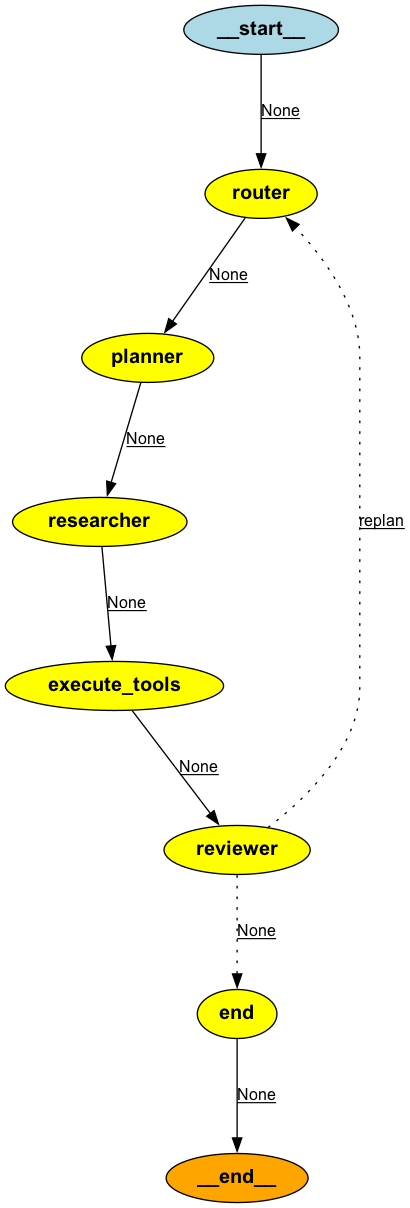

In [27]:
from IPython.display import Image, display
display(Image(workflow.get_graph().draw_png()))

In [28]:
# Define workflow parameters
iterations = 10
verbose = False
query = "Who's the current president of the USA?"
dict_inputs = {"research_question": query}
limit = {"recursion_limit": iterations}

# Execute the workflow and print state changes
for event in workflow.stream(dict_inputs, limit):
    if verbose:
        print("\nState Dictionary:", event)
    else:
        print("\n")

Router 🧭: content='{"next_agent": "selector"}'


Planner 👩🏿‍💻: content='{"steps": [{"step_number": 1, "task": "Gather current information about the President of the United States", "agent": "Researcher", "expected_result": "A list of current and recent Presidents, including their terms in office"}, {"step_number": 2, "task": "Review the gathered information to identify the current President", "agent": "Reviewer", "expected_result": "Verification that the researcher has provided accurate and up-to-date information about the current President"}]}'


Researcher 🕵️‍♂️: content='{"selected_tool": "wikipedia", "tool_input": {"query": "Current President of the United States"}}'


Selected Tool 🪛: wikipedia Input:{'query': 'Current President of the United States'}
Result:
Page: President of the United States
Summary: The president of the United States (POTUS) is the head of state and head of government of the United States of America. The president directs the executiv


Reviewer 🕵️‍♂️: conten